In [ ]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,OrdinalEncoder
from xgboost import XGBClassifier

import  matplotlib.pyplot as plt
import seaborn as sns
import sklearn



%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [ ]:
data = pd.read_csv('H2HBABBA3269.csv')

In [ ]:
data

In [ ]:
data.info()

In [ ]:
data.isna().sum()

# Removing Nan Columns

In [ ]:
#since area_buisness in NaN we drop it
data=data.drop(columns=['area_business'])

In [ ]:
data.shape

# Spilliting the data

In [ ]:
main_train = data[data.clear_date.isnull()==False]
main_test = data[data.clear_date.isnull()]

In [ ]:
data.isna().sum()

In [ ]:
main_train=main_train.dropna()

# Droping contants features

In [ ]:
# droping the constant features i.e document type ,posting_id,is_open
main_train = main_train.drop(columns = ['isOpen', 'posting_id','document type'])

In [ ]:
main_train

# Removing Duplicate columns

In [ ]:
#remove duplicate columns since invoice id and documnet id are the same

main_train= main_train.drop(columns=['doc_id'])

# Removing column having unique entries

In [ ]:
# now since invice id in unique so we are going to drop it
main_train=main_train.drop(columns='invoice_id')

# Removing Irrelevent Columns

In [ ]:
#now we are going to remove irrelevant columns which not effect predict model
main_train=main_train.drop(columns=['name_customer','document_create_date'])

In [ ]:
main_train

In [18]:
main_train.nunique()

business_code                 6
cust_number                1350
clear_date                  397
buisness_year                 2
posting_date                422
document_create_date.1      422
due_in_date                 489
invoice_currency              2
total_open_amount         35527
baseline_create_date        431
cust_payment_terms           72
dtype: int64

# Date Time Conversion

In [19]:
main_train['document_create_date.1']=pd.to_datetime(main_train['document_create_date.1'], format='%Y%m%d')
main_train['due_in_date']=pd.to_datetime(main_train['due_in_date'], format='%Y%m%d')
main_train['baseline_create_date']=pd.to_datetime(main_train['baseline_create_date'], format='%Y%m%d')
main_train['clear_date']=pd.to_datetime(main_train['clear_date']).dt.date  #removing the time part sice its zero evrywhere
main_train['clear_date']=pd.to_datetime(main_train.clear_date) #string object to datetime

In [20]:
main_train['posting_date']=pd.to_datetime(main_train['posting_date'])

# Sorting the entries by Posting date

In [21]:
main_train.sort_values(by=['posting_date'],inplace=True)

# #some invoices are created before  baseline create date so we are removing those here Kind of Outlier

In [22]:
temp = pd.Series(main_train['document_create_date.1'] - main_train['baseline_create_date']).dt.days

In [23]:
rows_to_drop = temp.value_counts().to_frame(name = 'count')

In [24]:
# No. of rows to drop satisfying the condition
rows_to_drop[(rows_to_drop.index <0)].sum()

count    2545
dtype: int64

In [25]:
main_train = main_train[((temp==0) | (temp>0))].reset_index(drop=True)

In [26]:
#now removing document_create_date.1 date since all the are now coreect 
main_train = main_train.drop(columns = ['document_create_date.1'])

In [27]:
main_train.dtypes , main_train.shape

(business_code                   object
 cust_number                     object
 clear_date              datetime64[ns]
 buisness_year                  float64
 posting_date            datetime64[ns]
 due_in_date             datetime64[ns]
 invoice_currency                object
 total_open_amount              float64
 baseline_create_date    datetime64[ns]
 cust_payment_terms              object
 dtype: object,
 (37454, 10))

# Adding column like payemnt term delay due term in the main_train

In [28]:
main_train['payment_term']=pd.Series(main_train['clear_date'] - main_train['baseline_create_date']).dt.days
main_train['due_term']=pd.Series(main_train['due_in_date'] - main_train['baseline_create_date']).dt.days
main_train['delay'] = main_train['payment_term'] - main_train['due_term']


In [377]:
#now droping payment term beacuse cant use in main test clear date is none there
main_train = main_train.drop(columns = ['payment_term'])


In [378]:
main_train = main_train.drop(columns = ['clear_date'])

In [379]:
main_train

,business_code,cust_number,buisness_year,posting_date,due_in_date,invoice_currency,total_open_amount,baseline_create_date,cust_payment_terms,due_term,delay
0,U001,0200769623,2019.0,2018-12-30,2019-01-14,USD,580.67,2018-12-30,NAH4,15,-5
1,U001,0200794332,2019.0,2018-12-30,2019-01-14,USD,15284.38,2018-12-30,NAAX,15,1
2,U001,0200769623,2019.0,2018-12-30,2019-01-14,USD,28485.61,2018-12-30,NAH4,15,-5
3,U001,0200726979,2019.0,2018-12-30,2019-01-14,USD,186.40,2018-12-30,NAA8,15,1
4,U001,0200014556,2019.0,2018-12-30,2019-01-14,USD,69249.78,2018-12-30,NAA8,15,0
...,...,...,...,...,...,...,...,...,...,...,...
37449,U001,0200780383,2020.0,2020-02-27,2020-03-13,USD,48029.58,2020-02-27,NAA8,15,4
37450,U001,0200759878,2020.0,2020-02-27,2020-03-13,USD,65988.21,2020-02-27,NAH4,15,0
37451,U001,0200721330,2020.0,2020-02-27,2020-03-08,USD,77434.89,2020-02-27,NA10,10,4
37452,U001,0200759878,2020.0,2020-02-27,2020-03-13,USD,65988.21,2020-02-27,NAH4,15,0


# Split Data

In [311]:

# Converting the main_train into X and y so that we can pass it onto train_test_split function

# X --> contains the dataframe without the target i.e payment_term
X = main_train.drop('delay',axis=1)

# y --> contains only the target value 
y = main_train['delay']

In [312]:
#splitting the data first into two part -- doing a 70:30 split i.e 30% data fed to intermediate test data set
from sklearn.model_selection import train_test_split
X_train,X_inter_test,y_train,y_inter_test = train_test_split(X,y,test_size=0.3,random_state=0 , shuffle = False)

In [313]:
X_val,X_test,y_val,y_test = train_test_split(X_inter_test,y_inter_test,test_size=0.5,random_state=0 , shuffle = False)

In [314]:
X_train.shape , X_val.shape , X_test.shape

((26217, 10), (5618, 10), (5619, 10))

# EDA

<AxesSubplot:xlabel='delay', ylabel='Density'>

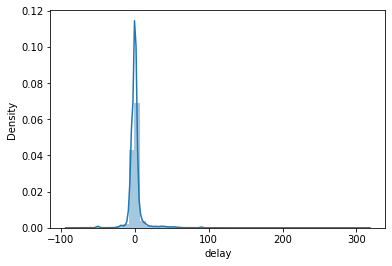

In [315]:
# distribution of the target column 
# slight skewed distribution
# outliers present but not that significant , hence  
sns.distplot(y_train)

<AxesSubplot:xlabel='delay', ylabel='posting_date'>

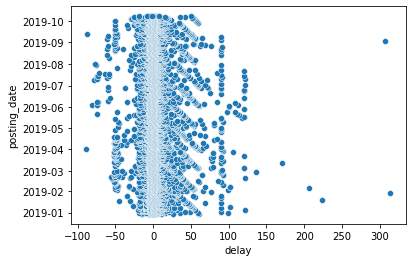

In [316]:
#No direct trend
sns.scatterplot(data=X_train.merge(y_train,on = X_train.index), x="delay", y="posting_date")

# Feature Engineering

In [317]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26217 entries, 0 to 26216
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   business_code         26217 non-null  object        
 1   cust_number           26217 non-null  object        
 2   buisness_year         26217 non-null  float64       
 3   posting_date          26217 non-null  datetime64[ns]
 4   due_in_date           26217 non-null  datetime64[ns]
 5   invoice_currency      26217 non-null  object        
 6   total_open_amount     26217 non-null  float64       
 7   baseline_create_date  26217 non-null  datetime64[ns]
 8   cust_payment_terms    26217 non-null  object        
 9   due_term              26217 non-null  int64         
dtypes: datetime64[ns](3), float64(2), int64(1), object(4)
memory usage: 2.2+ MB


# Label Encoding


In [318]:
from sklearn.preprocessing import LabelEncoder
invoice_currency_encoder = LabelEncoder()
invoice_currency_encoder.fit(X_train['invoice_currency'])
X_train['invoice_currency'] = invoice_currency_encoder.transform(X_train['invoice_currency'])

In [319]:
X_val['invoice_currency'] = invoice_currency_encoder.transform(X_val['invoice_currency'])
X_test['invoice_currency'] = invoice_currency_encoder.transform(X_test['invoice_currency'])

In [320]:
business_code_encoder = LabelEncoder()
business_code_encoder.fit(X_train['business_code'])
X_train['business_code'] = business_code_encoder.transform(X_train['business_code'])

In [321]:
X_val['business_code'] = business_code_encoder.transform(X_val['business_code'])
X_test['business_code'] = business_code_encoder.transform(X_test['business_code'])

In [322]:
cust_number_encoder = LabelEncoder()
cust_number_encoder.fit(X_train['cust_number'])
X_train['cust_number'] = cust_number_encoder.transform(X_train['cust_number'])

In [323]:
# finding what are the new catagories in the validation set
diff = set(X_val['cust_number'])-set(cust_number_encoder.classes_)

# adding them to the classess variable // 
for items in diff:
    cust_number_encoder.classes_ = np.append(cust_number_encoder.classes_,items)


In [324]:
X_val['cust_number'] = cust_number_encoder.transform(X_val['cust_number'])


In [325]:
# doing same thing for test also

diff1 = set(X_test['cust_number'])-set(cust_number_encoder.classes_)

# adding them to the classess variable // 
for items in diff1:
    cust_number_encoder.classes_ = np.append(cust_number_encoder.classes_,items)


In [326]:
X_test['cust_number'] = cust_number_encoder.transform(X_test['cust_number'])

In [327]:
cust_payment_terms_encoder = LabelEncoder()
cust_payment_terms_encoder.fit(X_train['cust_payment_terms'])
X_train['cust_payment_terms'] = cust_payment_terms_encoder.transform(X_train['cust_payment_terms'])

In [328]:
# finding what are the new catagories in the validation set
diff3 = set(X_val['cust_payment_terms'])-set(cust_payment_terms_encoder.classes_)

# adding them to the classess variable // 
for items in diff3:
    cust_payment_terms_encoder.classes_ = np.append(cust_payment_terms_encoder.classes_,items)


In [329]:
X_val['cust_payment_terms'] = cust_payment_terms_encoder.transform(X_val['cust_payment_terms'])

In [330]:
diff4 = set(X_test['cust_payment_terms'])-set(cust_payment_terms_encoder.classes_)

# adding them to the classess variable // 
for items in diff4:
    cust_payment_terms_encoder.classes_ = np.append(cust_payment_terms_encoder.classes_,items)


In [331]:
X_test['cust_payment_terms'] = cust_payment_terms_encoder.transform(X_test['cust_payment_terms'])

In [332]:
X_train.dtypes

business_code                    int32
cust_number                      int32
buisness_year                  float64
posting_date            datetime64[ns]
due_in_date             datetime64[ns]
invoice_currency                 int32
total_open_amount              float64
baseline_create_date    datetime64[ns]
cust_payment_terms               int32
due_term                         int64
dtype: object

### droping posting days since no use in prediction 

In [333]:
X_train=X_train.drop(columns=['posting_date'])
X_val=X_val.drop(columns=['posting_date'])
X_test=X_test.drop(columns=['posting_date'])

### Splitting dates into days moth year

In [334]:
def helper_map(col ,traindf = X_train,valdf = X_val,testdf = X_test):
    traindf.drop(col, axis =1,inplace=True)
    valdf.drop(col,axis=1 , inplace=True)
    testdf.drop(col,axis=1 , inplace=True)

    return traindf,valdf ,testdf

In [335]:
X_train['due_in_date.days'] = X_train['due_in_date'].dt.day
X_train['due_in_date.month'] = X_train['due_in_date'].dt.month
X_train['due_in_date.year'] = X_train['due_in_date'].dt.year

X_val['due_in_date.days'] = X_val['due_in_date'].dt.day
X_val['due_in_date.month'] = X_val['due_in_date'].dt.month
X_val['due_in_date.year'] = X_val['due_in_date'].dt.year

X_test['due_in_date.days'] = X_test['due_in_date'].dt.day
X_test['due_in_date.month'] = X_test['due_in_date'].dt.month
X_test['due_in_date.year'] = X_test['due_in_date'].dt.year

In [336]:
X_train ,X_val, X_test = helper_map(['due_in_date'])

In [337]:
X_train['baseline_create_date.days'] = X_train['baseline_create_date'].dt.day
X_train['baseline_create_date.month'] = X_train['baseline_create_date'].dt.month
X_train['baseline_create_date.year'] = X_train['baseline_create_date'].dt.year

X_val['baseline_create_date.days'] = X_val['baseline_create_date'].dt.day
X_val['baseline_create_date.month'] = X_val['baseline_create_date'].dt.month
X_val['baseline_create_date.year'] = X_val['baseline_create_date'].dt.year

X_test['baseline_create_date.days'] = X_test['baseline_create_date'].dt.day
X_test['baseline_create_date.month'] = X_test['baseline_create_date'].dt.month
X_test['baseline_create_date.year'] = X_test['baseline_create_date'].dt.year

In [338]:
X_train ,X_val, X_test = helper_map(['baseline_create_date'])

In [342]:
X_train.reset_index(drop=True,inplace=True)

# Feature Selection

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

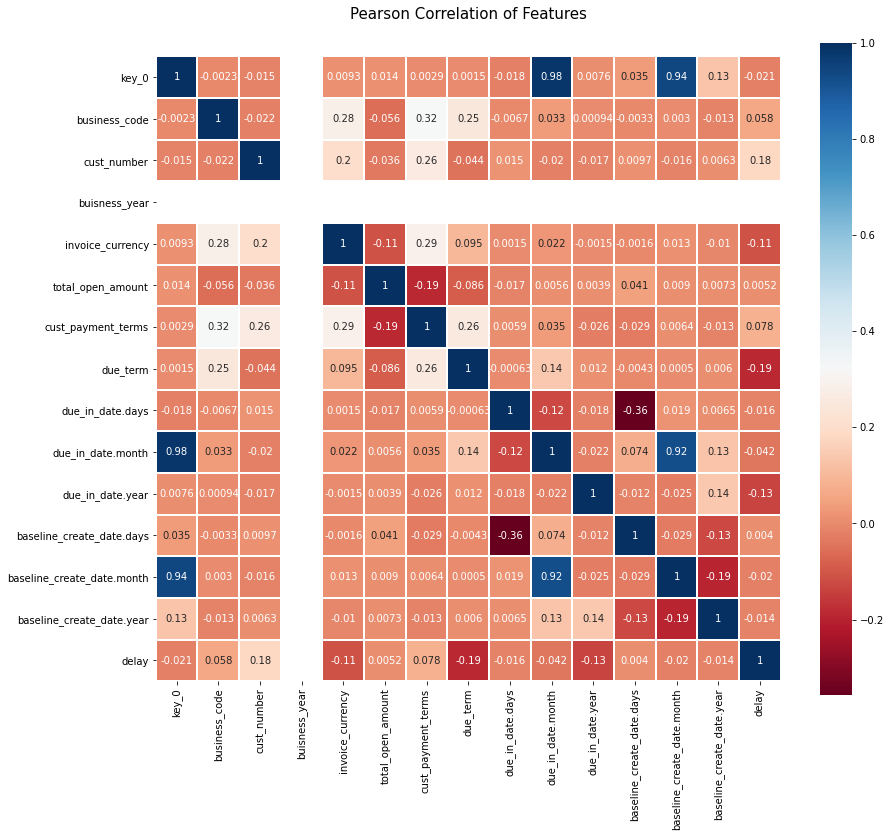

In [343]:
#Feature Selection

#corrmat = X_train.merge(y_train , on = X_train.index).corr()
# plt.subplots(figsize=(12,9))
# sns.heatmap(corrmat, vmax=0.9, square=True)


colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(X_train.merge(y_train , on = X_train.index ).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

### Here we can see buisnes_year , clear_date_year are constant columns and should be removed

In [344]:
X_train=X_train.drop(columns=['buisness_year'])
X_val=X_val.drop(columns=['buisness_year'])
X_test=X_test.drop(columns=['buisness_year'])

In [345]:
X_train


,business_code,cust_number,invoice_currency,total_open_amount,cust_payment_terms,due_term,due_in_date.days,due_in_date.month,due_in_date.year,baseline_create_date.days,baseline_create_date.month,baseline_create_date.year
0,1,658,1,580.67,31,15,14,1,2019,30,12,2018
1,1,726,1,15284.38,19,15,14,1,2019,30,12,2018
2,1,658,1,28485.61,31,15,14,1,2019,30,12,2018
3,1,566,1,186.40,17,15,14,1,2019,30,12,2018
4,1,290,1,69249.78,17,15,14,1,2019,30,12,2018
...,...,...,...,...,...,...,...,...,...,...,...,...
26212,1,566,1,353.80,17,15,23,10,2019,8,10,2019
26213,1,658,1,29750.35,31,15,23,10,2019,8,10,2019
26214,1,609,1,350.40,17,15,23,10,2019,8,10,2019
26215,1,360,1,103.92,35,23,24,10,2019,1,10,2019


<AxesSubplot:xlabel='delay', ylabel='total_open_amount'>

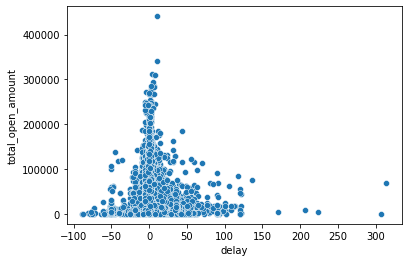

In [347]:
#No direct trend
sns.scatterplot(data=X_train.merge(y_train,on = X_train.index), x="delay",y='total_open_amount')

# Modelling

## create a base model

In [66]:
from sklearn.linear_model import LinearRegression
base_model = LinearRegression()
base_model.fit(X_train, y_train)

LinearRegression()

In [67]:
y_predict = base_model.predict(X_val)

In [68]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_val, y_predict, squared=False)

9.790893485979101

In [69]:
met = pd.DataFrame(zip(y_predict , y_val),columns=['Predicted','Actuals'])

## Tree Based model

In [70]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=0 , max_depth=5)

In [71]:
regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, random_state=0)

In [72]:
y_predict2 = regressor.predict(X_val)

In [73]:
mean_squared_error(y_val, y_predict2, squared=False)

5.14362645119983

# Now predicting on the test set 

In [74]:
y_predict_test = regressor.predict(X_test)
mean_squared_error(y_test, y_predict_test, squared=False)

8.631282361370033

In [75]:
y_predict_test = base_model.predict(X_test)

In [76]:
mean_squared_error(y_val, y_predict2, squared=False)

5.14362645119983

In [77]:
X_train

,business_code,cust_number,invoice_currency,total_open_amount,cust_payment_terms,due_term,due_in_date.days,due_in_date.month,due_in_date.year,baseline_create_date.days,baseline_create_date.month,baseline_create_date.year
0,1,658,1,580.67,31,15,14,1,2019,30,12,2018
1,1,726,1,15284.38,19,15,14,1,2019,30,12,2018
2,1,658,1,28485.61,31,15,14,1,2019,30,12,2018
3,1,566,1,186.40,17,15,14,1,2019,30,12,2018
4,1,290,1,69249.78,17,15,14,1,2019,30,12,2018
...,...,...,...,...,...,...,...,...,...,...,...,...
26212,1,566,1,353.80,17,15,23,10,2019,8,10,2019
26213,1,658,1,29750.35,31,15,23,10,2019,8,10,2019
26214,1,609,1,350.40,17,15,23,10,2019,8,10,2019
26215,1,360,1,103.92,35,23,24,10,2019,1,10,2019


# Now on main_TEST set

In [78]:
main_test

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen
2,U001,0200726979,BJ'S llc,NaN,2020.0,1.930587e+09,2020-03-03,20200302,20200303,20200318.0,USD,RV,1.0,336.08,20200303.0,NAA8,1.930587e+09,1
9,U001,200418007,AM systems,NaN,2020.0,1.930841e+09,2020-05-01,20200430,20200501,20200516.0,USD,RV,1.0,33697.73,20200501.0,NAA8,1.930841e+09,1
11,U001,0200900212,CASEY us,NaN,2020.0,1.930823e+09,2020-04-24,20200424,20200424,20200509.0,USD,RV,1.0,24804.94,20200424.0,NAA8,1.930823e+09,1
16,U001,0200769623,WAL-MAR,NaN,2020.0,1.930834e+09,2020-04-29,20200428,20200429,20200514.0,USD,RV,1.0,4821.77,20200429.0,NAH4,1.930834e+09,1
19,U001,0200984794,GREA llc,NaN,2020.0,1.930703e+09,2020-03-25,20200325,20200325,20200409.0,USD,RV,1.0,8873.08,20200325.0,NAA8,1.930703e+09,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49993,U002,0200978592,PLAZA corporation,NaN,2020.0,1.990572e+09,2020-04-01,20200331,20200401,20200506.0,USD,RV,1.0,55792.19,20200401.0,NAG2,1.990572e+09,1
49994,U001,0200936373,SUPE trust,NaN,2020.0,1.930704e+09,2020-03-26,20200326,20200326,20200410.0,USD,RV,1.0,10912.65,20200326.0,NAA8,1.930704e+09,1
49996,U001,0200769623,WAL-MAR co,NaN,2020.0,1.930799e+09,2020-04-18,20200418,20200418,20200503.0,USD,RV,1.0,2325.38,20200418.0,NAH4,1.930799e+09,1
49997,U001,0200769623,WAL-MAR in,NaN,2020.0,1.930859e+09,2020-05-05,20200505,20200505,20200520.0,USD,RV,1.0,44462.63,20200505.0,NAH4,1.930859e+09,1


In [79]:
main_test.isna().sum()


business_code                 0
cust_number                   0
name_customer                 0
clear_date                10000
buisness_year                 0
doc_id                        0
posting_date                  0
document_create_date          0
document_create_date.1        0
due_in_date                   0
invoice_currency              0
document type                 0
posting_id                    0
total_open_amount             0
baseline_create_date          0
cust_payment_terms            0
invoice_id                    0
isOpen                        0
dtype: int64

In [80]:
X_main_test = main_test.drop(['clear_date'],axis=1)


In [81]:
X_main_test

,business_code,cust_number,name_customer,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen
2,U001,0200726979,BJ'S llc,2020.0,1.930587e+09,2020-03-03,20200302,20200303,20200318.0,USD,RV,1.0,336.08,20200303.0,NAA8,1.930587e+09,1
9,U001,200418007,AM systems,2020.0,1.930841e+09,2020-05-01,20200430,20200501,20200516.0,USD,RV,1.0,33697.73,20200501.0,NAA8,1.930841e+09,1
11,U001,0200900212,CASEY us,2020.0,1.930823e+09,2020-04-24,20200424,20200424,20200509.0,USD,RV,1.0,24804.94,20200424.0,NAA8,1.930823e+09,1
16,U001,0200769623,WAL-MAR,2020.0,1.930834e+09,2020-04-29,20200428,20200429,20200514.0,USD,RV,1.0,4821.77,20200429.0,NAH4,1.930834e+09,1
19,U001,0200984794,GREA llc,2020.0,1.930703e+09,2020-03-25,20200325,20200325,20200409.0,USD,RV,1.0,8873.08,20200325.0,NAA8,1.930703e+09,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49993,U002,0200978592,PLAZA corporation,2020.0,1.990572e+09,2020-04-01,20200331,20200401,20200506.0,USD,RV,1.0,55792.19,20200401.0,NAG2,1.990572e+09,1
49994,U001,0200936373,SUPE trust,2020.0,1.930704e+09,2020-03-26,20200326,20200326,20200410.0,USD,RV,1.0,10912.65,20200326.0,NAA8,1.930704e+09,1
49996,U001,0200769623,WAL-MAR co,2020.0,1.930799e+09,2020-04-18,20200418,20200418,20200503.0,USD,RV,1.0,2325.38,20200418.0,NAH4,1.930799e+09,1
49997,U001,0200769623,WAL-MAR in,2020.0,1.930859e+09,2020-05-05,20200505,20200505,20200520.0,USD,RV,1.0,44462.63,20200505.0,NAH4,1.930859e+09,1


# Preprocessing 

### same step as in above main train set 

In [82]:
# droping the constant features i.e document type ,posting_id,is_open
X_main_test = X_main_test.drop(columns = ['isOpen', 'posting_id','document type'])

In [83]:
#remove duplicate columns since invoice id and documnet id are the same
X_main_test= X_main_test.drop(columns=['doc_id'])

# Removing column having unique entries

In [84]:
# now since invice id in unique so we are going to drop it
X_main_test=X_main_test.drop(columns='invoice_id')

# Removing Irrelevent Columns

In [85]:
#now we are going to remove irrelevant columns which not effect predict model
X_main_test=X_main_test.drop(columns=['name_customer','document_create_date'])

# Date Time Conversion

In [86]:
X_main_test['document_create_date.1']=pd.to_datetime(X_main_test['document_create_date.1'], format='%Y%m%d')
X_main_test['due_in_date']=pd.to_datetime(X_main_test['due_in_date'], format='%Y%m%d')
X_main_test['baseline_create_date']=pd.to_datetime(X_main_test['baseline_create_date'], format='%Y%m%d')
X_main_test['posting_date']=pd.to_datetime(X_main_test['posting_date'])

# Sorting the entries by Posting date

In [87]:
X_main_test.sort_values(by=['posting_date'],inplace=True)

### some invoices are created before baseline create date so we are removing those here


In [88]:
temp1 = pd.Series(X_main_test['document_create_date.1'] - X_main_test['baseline_create_date']).dt.days

In [89]:
rows_to_drop = temp1.value_counts().to_frame(name = 'count')


In [90]:
# No. of rows to drop satisfying the condition
rows_to_drop[(rows_to_drop.index <0)].sum()

count    583
dtype: int64

In [91]:
X_main_test = X_main_test[((temp1==0) | (temp1>0))].reset_index(drop=True)

# now removing document_create_date.1 date since all the are now correct


In [92]:
X_main_test = X_main_test.drop(columns = ['document_create_date.1'])
X_main_test.dtypes , X_main_test.shape

(business_code                   object
 cust_number                     object
 buisness_year                  float64
 posting_date            datetime64[ns]
 due_in_date             datetime64[ns]
 invoice_currency                object
 total_open_amount              float64
 baseline_create_date    datetime64[ns]
 cust_payment_terms              object
 dtype: object,
 (9417, 9))

In [93]:
X_main_test['due_term']=pd.Series(X_main_test['due_in_date'] - X_main_test['baseline_create_date']).dt.days

In [94]:
X_main_test

,business_code,cust_number,buisness_year,posting_date,due_in_date,invoice_currency,total_open_amount,baseline_create_date,cust_payment_terms,due_term
0,U001,0200762950,2020.0,2020-02-27,2020-03-13,USD,140884.32,2020-02-27,NAA8,15
1,U001,0200726979,2020.0,2020-02-27,2020-03-13,USD,35.73,2020-02-27,NAA8,15
2,U001,0200759878,2020.0,2020-02-27,2020-05-02,USD,7446.60,2020-02-27,NAGD,65
3,U001,0200063296,2020.0,2020-02-27,2020-03-28,USD,20490.45,2020-02-27,NAD5,30
4,U013,0100011958,2020.0,2020-02-27,2020-04-12,USD,10594.06,2020-02-27,NAVF,45
...,...,...,...,...,...,...,...,...,...,...
9412,U001,0200712836,2020.0,2020-05-13,2020-05-28,USD,589.76,2020-05-13,NAA8,15
9413,U001,0200413833,2020.0,2020-05-13,2020-05-28,USD,33140.44,2020-05-13,NAA8,15
9414,U001,0200762950,2020.0,2020-05-13,2020-05-28,USD,136025.60,2020-05-13,NAA8,15
9415,U001,200875680,2020.0,2020-05-13,2020-05-28,USD,77253.74,2020-05-13,NAA8,15


# Label Encoding

In [95]:
# Again new classed are there in the main_test set
temp = set(X_main_test['business_code'])-set(business_code_encoder.classes_)
for items in temp:
    business_code_encoder.classes_= np.append(business_code_encoder.classes_,items)

X_main_test['business_code'] = business_code_encoder.transform(X_main_test['business_code'])

In [96]:
# Again new classed are there in the main_test set
temp1 = set(X_main_test['cust_number'])-set(cust_number_encoder.classes_)
for items in temp1:
    cust_number_encoder.classes_= np.append(cust_number_encoder.classes_,items)

X_main_test['cust_number'] = cust_number_encoder.transform(X_main_test['cust_number'])

In [97]:
# Again new classed are there in the main_test set
temp3 = set(X_main_test['invoice_currency'])-set(invoice_currency_encoder.classes_)
for items in temp3:
    invoice_currency_encoder.classes_= np.append(invoice_currency_encoder.classes_,items)

X_main_test['invoice_currency'] = invoice_currency_encoder.transform(X_main_test['invoice_currency'])

In [98]:
# Again new classed are there in the main_test set
temp4 = set(X_main_test['cust_payment_terms'])-set(cust_payment_terms_encoder.classes_)
for items in temp4:
    cust_payment_terms_encoder.classes_= np.append(cust_payment_terms_encoder.classes_,items)

X_main_test['cust_payment_terms'] = cust_payment_terms_encoder.transform(X_main_test['cust_payment_terms'])

In [99]:
X_main_test=X_main_test.drop(columns=['posting_date'])

In [100]:
X_main_test['due_in_date.days'] = X_main_test['due_in_date'].dt.day
X_main_test['due_in_date.month'] = X_main_test['due_in_date'].dt.month
X_main_test['due_in_date.year'] = X_main_test['due_in_date'].dt.year

In [101]:
X_main_test=X_main_test.drop(columns=['due_in_date'])

In [102]:
X_main_test['baseline_create_date.days'] = X_main_test['baseline_create_date'].dt.day
X_main_test['baseline_create_date.month'] = X_main_test['baseline_create_date'].dt.month
X_main_test['baseline_create_date.year'] = X_main_test['baseline_create_date'].dt.year

In [103]:
X_main_test=X_main_test.drop(columns=['baseline_create_date'])

In [104]:
#since we already know from corealtion matrix that business year is constant
X_main_test=X_main_test.drop(columns=['buisness_year'])

In [105]:
X_main_test

,business_code,cust_number,invoice_currency,total_open_amount,cust_payment_terms,due_term,due_in_date.days,due_in_date.month,due_in_date.year,baseline_create_date.days,baseline_create_date.month,baseline_create_date.year
0,1,645,1,140884.32,17,15,13,3,2020,27,2,2020
1,1,566,1,35.73,17,15,13,3,2020,27,2,2020
2,1,637,1,7446.60,30,65,2,5,2020,27,2,2020
3,1,306,1,20490.45,27,30,28,3,2020,27,2,2020
4,5,29,1,10594.06,46,45,12,4,2020,27,2,2020
...,...,...,...,...,...,...,...,...,...,...,...,...
9412,1,542,1,589.76,17,15,28,5,2020,13,5,2020
9413,1,419,1,33140.44,17,15,28,5,2020,13,5,2020
9414,1,645,1,136025.60,17,15,28,5,2020,13,5,2020
9415,1,1231,1,77253.74,17,15,28,5,2020,13,5,2020


In [106]:
X_main_test.columns

Index(['business_code', 'cust_number', 'invoice_currency', 'total_open_amount',
       'cust_payment_terms', 'due_term', 'due_in_date.days',
       'due_in_date.month', 'due_in_date.year', 'baseline_create_date.days',
       'baseline_create_date.month', 'baseline_create_date.year'],
      dtype='object')

In [107]:
X_train.columns

Index(['business_code', 'cust_number', 'invoice_currency', 'total_open_amount',
       'cust_payment_terms', 'due_term', 'due_in_date.days',
       'due_in_date.month', 'due_in_date.year', 'baseline_create_date.days',
       'baseline_create_date.month', 'baseline_create_date.year'],
      dtype='object')

# Final Prediction

In [108]:
final_result = regressor.predict(X_main_test)

In [109]:
final_result = pd.Series(final_result,name='delay')

In [110]:
# resetting the index of main test so that we can merge price series with it
main_test.reset_index(drop=True,inplace=True)

In [111]:
main_test

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen
0,U001,0200726979,BJ'S llc,NaN,2020.0,1.930587e+09,2020-03-03,20200302,20200303,20200318.0,USD,RV,1.0,336.08,20200303.0,NAA8,1.930587e+09,1
1,U001,200418007,AM systems,NaN,2020.0,1.930841e+09,2020-05-01,20200430,20200501,20200516.0,USD,RV,1.0,33697.73,20200501.0,NAA8,1.930841e+09,1
2,U001,0200900212,CASEY us,NaN,2020.0,1.930823e+09,2020-04-24,20200424,20200424,20200509.0,USD,RV,1.0,24804.94,20200424.0,NAA8,1.930823e+09,1
3,U001,0200769623,WAL-MAR,NaN,2020.0,1.930834e+09,2020-04-29,20200428,20200429,20200514.0,USD,RV,1.0,4821.77,20200429.0,NAH4,1.930834e+09,1
4,U001,0200984794,GREA llc,NaN,2020.0,1.930703e+09,2020-03-25,20200325,20200325,20200409.0,USD,RV,1.0,8873.08,20200325.0,NAA8,1.930703e+09,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,U002,0200978592,PLAZA corporation,NaN,2020.0,1.990572e+09,2020-04-01,20200331,20200401,20200506.0,USD,RV,1.0,55792.19,20200401.0,NAG2,1.990572e+09,1
9996,U001,0200936373,SUPE trust,NaN,2020.0,1.930704e+09,2020-03-26,20200326,20200326,20200410.0,USD,RV,1.0,10912.65,20200326.0,NAA8,1.930704e+09,1
9997,U001,0200769623,WAL-MAR co,NaN,2020.0,1.930799e+09,2020-04-18,20200418,20200418,20200503.0,USD,RV,1.0,2325.38,20200418.0,NAH4,1.930799e+09,1
9998,U001,0200769623,WAL-MAR in,NaN,2020.0,1.930859e+09,2020-05-05,20200505,20200505,20200520.0,USD,RV,1.0,44462.63,20200505.0,NAH4,1.930859e+09,1


In [112]:
main_test['document_create_date.1']=pd.to_datetime(main_test['document_create_date.1'], format='%Y%m%d')
main_test['due_in_date']=pd.to_datetime(main_test['due_in_date'], format='%Y%m%d')
main_test['baseline_create_date']=pd.to_datetime(main_test['baseline_create_date'], format='%Y%m%d')
main_test['posting_date']=pd.to_datetime(main_test['posting_date'])

# some invoices are created before baseline create date so we are removing those here


In [113]:
temp_main = pd.Series(main_test['document_create_date.1'] - main_test['baseline_create_date']).dt.days
temp_main = pd.Series(main_test['document_create_date.1'] - main_test['baseline_create_date']).dt.days
rows_to_drop = temp_main.value_counts().to_frame(name = 'count')

In [114]:
# No. of rows to drop satisfying the condition
rows_to_drop[(rows_to_drop.index <0)].sum()

count    583
dtype: int64

In [115]:
main_test = main_test[((temp_main==0) | (temp_main>0))].reset_index(drop=True)

# Below table showing delays in payment mapped against Main_test 

In [116]:
Final = main_test.merge(final_result , on = X_main_test.index )
Final

,key_0,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen,delay
0,0,U001,0200726979,BJ'S llc,NaN,2020.0,1.930587e+09,2020-03-03,20200302,2020-03-03,2020-03-18,USD,RV,1.0,336.08,2020-03-03,NAA8,1.930587e+09,1,1.406478
1,1,U001,200418007,AM systems,NaN,2020.0,1.930841e+09,2020-05-01,20200430,2020-05-01,2020-05-16,USD,RV,1.0,33697.73,2020-05-01,NAA8,1.930841e+09,1,1.406478
2,2,U001,0200900212,CASEY us,NaN,2020.0,1.930823e+09,2020-04-24,20200424,2020-04-24,2020-05-09,USD,RV,1.0,24804.94,2020-04-24,NAA8,1.930823e+09,1,-7.102468
3,3,U001,0200769623,WAL-MAR,NaN,2020.0,1.930834e+09,2020-04-29,20200428,2020-04-29,2020-05-14,USD,RV,1.0,4821.77,2020-04-29,NAH4,1.930834e+09,1,1.406478
4,4,U001,0200984794,GREA llc,NaN,2020.0,1.930703e+09,2020-03-25,20200325,2020-03-25,2020-04-09,USD,RV,1.0,8873.08,2020-03-25,NAA8,1.930703e+09,1,-7.102468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9412,9412,U002,0200978592,PLAZA corporation,NaN,2020.0,1.990572e+09,2020-04-01,20200331,2020-04-01,2020-05-06,USD,RV,1.0,55792.19,2020-04-01,NAG2,1.990572e+09,1,1.406478
9413,9413,U001,0200936373,SUPE trust,NaN,2020.0,1.930704e+09,2020-03-26,20200326,2020-03-26,2020-04-10,USD,RV,1.0,10912.65,2020-03-26,NAA8,1.930704e+09,1,1.406478
9414,9414,U001,0200769623,WAL-MAR co,NaN,2020.0,1.930799e+09,2020-04-18,20200418,2020-04-18,2020-05-03,USD,RV,1.0,2325.38,2020-04-18,NAH4,1.930799e+09,1,1.406478
9415,9415,U001,0200769623,WAL-MAR in,NaN,2020.0,1.930859e+09,2020-05-05,20200505,2020-05-05,2020-05-20,USD,RV,1.0,44462.63,2020-05-05,NAH4,1.930859e+09,1,9.235294


# Calculating Predicted Payment Date

In [117]:
from datetime import timedelta, date

In [118]:
Final['INVOICE PAYMENT TERM']=Final['delay']

In [119]:
Final['Predicted PAYMENT DATE'] = Final['due_in_date'] + pd.to_timedelta(np.ceil(Final['INVOICE PAYMENT TERM']),'D')

In [120]:
Final = Final.drop(['INVOICE PAYMENT TERM'],axis=1)

In [121]:
Final.nunique()

key_0                     9417
business_code                5
cust_number                602
name_customer             1555
clear_date                   0
buisness_year                1
doc_id                    9153
posting_date                78
document_create_date        87
document_create_date.1      78
due_in_date                127
invoice_currency             2
document type                1
posting_id                   1
total_open_amount         8560
baseline_create_date        80
cust_payment_terms          36
invoice_id                9153
isOpen                       1
delay                       18
Predicted PAYMENT DATE     141
dtype: int64

In [122]:
def bucketization(x):
    if x<0:
        return('(< 0) Days')
    if x in range(0,16):
        return('(0-15) Days')
    elif x in range(16,31):
        return('(16-30) Days')
    elif x in range(31,45):
        return('(31-45) Days')
    elif x in range(45,60):
        return('(45-60) Days')
    else:
        return('(> 60) Days')

In [123]:
Final['Ageing Bucket']= pd.Series([bucketization(x=int(Final['delay'][i]))  for i in range(len(Final))])

In [124]:
Final

,key_0,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,...,document type,posting_id,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen,delay,Predicted PAYMENT DATE,Ageing Bucket
0,0,U001,0200726979,BJ'S llc,NaN,2020.0,1.930587e+09,2020-03-03,20200302,2020-03-03,...,RV,1.0,336.08,2020-03-03,NAA8,1.930587e+09,1,1.406478,2020-03-20,(0-15) Days
1,1,U001,200418007,AM systems,NaN,2020.0,1.930841e+09,2020-05-01,20200430,2020-05-01,...,RV,1.0,33697.73,2020-05-01,NAA8,1.930841e+09,1,1.406478,2020-05-18,(0-15) Days
2,2,U001,0200900212,CASEY us,NaN,2020.0,1.930823e+09,2020-04-24,20200424,2020-04-24,...,RV,1.0,24804.94,2020-04-24,NAA8,1.930823e+09,1,-7.102468,2020-05-02,(< 0) Days
3,3,U001,0200769623,WAL-MAR,NaN,2020.0,1.930834e+09,2020-04-29,20200428,2020-04-29,...,RV,1.0,4821.77,2020-04-29,NAH4,1.930834e+09,1,1.406478,2020-05-16,(0-15) Days
4,4,U001,0200984794,GREA llc,NaN,2020.0,1.930703e+09,2020-03-25,20200325,2020-03-25,...,RV,1.0,8873.08,2020-03-25,NAA8,1.930703e+09,1,-7.102468,2020-04-02,(< 0) Days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9412,9412,U002,0200978592,PLAZA corporation,NaN,2020.0,1.990572e+09,2020-04-01,20200331,2020-04-01,...,RV,1.0,55792.19,2020-04-01,NAG2,1.990572e+09,1,1.406478,2020-05-08,(0-15) Days
9413,9413,U001,0200936373,SUPE trust,NaN,2020.0,1.930704e+09,2020-03-26,20200326,2020-03-26,...,RV,1.0,10912.65,2020-03-26,NAA8,1.930704e+09,1,1.406478,2020-04-12,(0-15) Days
9414,9414,U001,0200769623,WAL-MAR co,NaN,2020.0,1.930799e+09,2020-04-18,20200418,2020-04-18,...,RV,1.0,2325.38,2020-04-18,NAH4,1.930799e+09,1,1.406478,2020-05-05,(0-15) Days
9415,9415,U001,0200769623,WAL-MAR in,NaN,2020.0,1.930859e+09,2020-05-05,20200505,2020-05-05,...,RV,1.0,44462.63,2020-05-05,NAH4,1.930859e+09,1,9.235294,2020-05-30,(0-15) Days


In [141]:
Final.head(200)

,key_0,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,...,document type,posting_id,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen,delay,Predicted PAYMENT DATE,Ageing Bucket
0,0,U001,0200726979,BJ'S llc,NaN,2020.0,1.930587e+09,2020-03-03,20200302,2020-03-03,...,RV,1.0,336.08,2020-03-03,NAA8,1.930587e+09,1,1.406478,2020-03-20,(0-15) Days
1,1,U001,200418007,AM systems,NaN,2020.0,1.930841e+09,2020-05-01,20200430,2020-05-01,...,RV,1.0,33697.73,2020-05-01,NAA8,1.930841e+09,1,1.406478,2020-05-18,(0-15) Days
2,2,U001,0200900212,CASEY us,NaN,2020.0,1.930823e+09,2020-04-24,20200424,2020-04-24,...,RV,1.0,24804.94,2020-04-24,NAA8,1.930823e+09,1,-7.102468,2020-05-02,(< 0) Days
3,3,U001,0200769623,WAL-MAR,NaN,2020.0,1.930834e+09,2020-04-29,20200428,2020-04-29,...,RV,1.0,4821.77,2020-04-29,NAH4,1.930834e+09,1,1.406478,2020-05-16,(0-15) Days
4,4,U001,0200984794,GREA llc,NaN,2020.0,1.930703e+09,2020-03-25,20200325,2020-03-25,...,RV,1.0,8873.08,2020-03-25,NAA8,1.930703e+09,1,-7.102468,2020-04-02,(< 0) Days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,U001,200936373,SUPE trust,NaN,2020.0,1.930632e+09,2020-03-10,20200310,2020-03-10,...,RV,1.0,18224.92,2020-03-10,NAGD,1.930632e+09,1,1.406478,2020-05-16,(0-15) Days
196,196,U001,0200726979,BJ'S llc,NaN,2020.0,1.930780e+09,2020-04-12,20200413,2020-04-12,...,RV,1.0,1361.10,2020-04-12,NAA8,1.930780e+09,1,-1.674585,2020-04-26,(< 0) Days
197,197,U001,0200592182,DECA corp,NaN,2020.0,1.930638e+09,2020-03-11,20200311,2020-03-11,...,RV,1.0,54.00,2020-03-01,NAM4,1.930638e+09,1,1.406478,2020-03-26,(0-15) Days
198,198,U001,0200726979,BJ'S in,NaN,2020.0,1.930723e+09,2020-03-31,20200331,2020-03-31,...,RV,1.0,750.26,2020-03-31,NAA8,1.930723e+09,1,-1.674585,2020-04-14,(< 0) Days


In [139]:
Final['delay'].max(axis=0)

120.0